In [1]:
from transformers import pipeline
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

# **BEFORE FINETUNING**

In [2]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/venkatareddykonasani/Datasets/master/Final_Emotion_Data/five_emotions_data.csv")
df.head()

,Id,Emotion,Text,label
0,1,sadness,i didnt feel humiliated,3
1,2,sadness,i can go from feeling so hopeless to so damned...,3
2,4,love,i am ever feeling nostalgic about the fireplac...,1
3,6,sadness,ive been feeling a little burdened lately wasn...,3
4,9,happiness,i have been with petronas for years i feel tha...,0


In [3]:
distilbert = pipeline(task='text-classification',model='distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Device set to use cuda:0


In [22]:
sample_data = df.sample(1000,random_state=42)
sample_data['Text'] = sample_data['Text'].apply(lambda x:" ".join(x.split()[:300]))
sample_data['Bert_predicted'] = sample_data['Text'].apply(lambda x : distilbert(x)[0]['label'][-1])


In [23]:
sample_data['Bert_predicted'] = sample_data['Bert_predicted'].astype(int)
sample_data.head(3)

,Id,Emotion,Text,label,Bert_predicted
1900,2690,sadness,i social and dreaming about things that make y...,3,0
20627,27544,worry,"is missing training tonight, the lurgy is on m...",4,0
12481,17415,worry,my HD is full. need to cleanup a lot,4,0


In [24]:
CM = confusion_matrix(sample_data['label'],sample_data['Bert_predicted'])
accuracy = CM.diagonal().sum() / CM.sum().astype(float)
print("Before FINE TUNING :")
print(f" COnfusion Matrix : \n{CM}")
print(f" Accuracy score : {accuracy}")

Before FINE TUNING :
 COnfusion Matrix : 
[[252   0   0   0   0]
 [116   0   0   0   0]
 [204   0   0   0   0]
 [225   0   0   0   0]
 [203   0   0   0   0]]
 Accuracy score : 0.252


# **Accuracy score : 25 %**

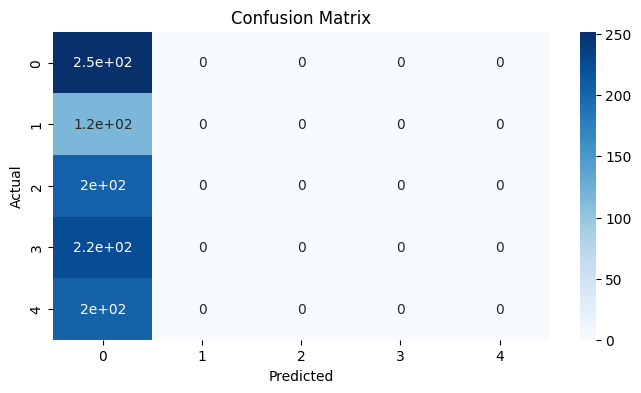

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sns.heatmap(CM,annot=True,cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [19]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [20]:
from transformers import Trainer, TrainingArguments
from datasets import load_dataset, DatasetDict, ClassLabel, Dataset

In [27]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

In [28]:
sample = Dataset.from_pandas(sample_data)
train_test_split = sample.train_test_split(test_size=0.2)
dataset = DatasetDict({
    'train':train_test_split['train'],
    'test' :train_test_split['test']
})
dataset

DatasetDict({
    train: Dataset({
        features: ['Id', 'Emotion', 'Text', 'label', 'Bert_predicted', '__index_level_0__'],
        num_rows: 800
    })
    test: Dataset({
        features: ['Id', 'Emotion', 'Text', 'label', 'Bert_predicted', '__index_level_0__'],
        num_rows: 200
    })
})

In [31]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.add_special_tokens({'pad_token':'[PAD]'})

def tokenize_function(examples):
  return tokenizer(examples['Text'], padding="max_length", truncation=True, max_length=100)
tokenized_dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [36]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5, pad_token_id = tokenizer.eos_token_id )
model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (li

In [62]:
training_args = TrainingArguments(
    output_dir = "./result_bert_custom",
    num_train_epochs = 25,
    logging_dir = "./logs",
    evaluation_strategy = "epoch"
)

trainer = Trainer(
    model = model,
    args = training_args,
    train_dataset = tokenized_dataset['train'],
    eval_dataset = tokenized_dataset['test']
)
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,4.839350
2,No log,5.117526
3,No log,4.861969
4,No log,4.357596
5,0.070700,4.686478
6,0.070700,4.812807
7,0.070700,4.913329
8,0.070700,4.776473
9,0.070700,5.062526
10,0.046800,5.118729


TrainOutput(global_step=2500, training_loss=0.026952793288230897, metrics={'train_runtime': 286.0831, 'train_samples_per_second': 69.91, 'train_steps_per_second': 8.739, 'total_flos': 517478460000000.0, 'train_loss': 0.026952793288230897, 'epoch': 25.0})

In [63]:
model_dir = "./distilbert_finetuned"
model.save_pretrained(model_dir)
tokenizer.save_pretrained(model_dir)
trainer.save_model('DistilBert_customModel_emotions')

In [39]:
import torch

In [64]:
def make_prediction(text):
  new_data = text
  inputs = tokenizer(new_data, return_tensors='pt')
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  inputs = inputs.to(device)
  outputs = model(**inputs)
  predictions = outputs.logits.argmax(-1)
  predictions = predictions.cpu().detach().numpy()
  return (predictions)

In [65]:
sample_df = sample.to_pandas()
sample_df['Finutuned_prediction'] = sample_df["Text"].apply(lambda x:make_prediction(x)[0])
sample_df.head(3)

,Id,Emotion,Text,label,Bert_predicted,__index_level_0__,Finutuned_prediction
0,2690,sadness,i social and dreaming about things that make y...,3,0,1900,3
1,27544,worry,"is missing training tonight, the lurgy is on m...",4,0,20627,4
2,17415,worry,my HD is full. need to cleanup a lot,4,0,12481,4


In [66]:
FCM = confusion_matrix(sample_df['label'],sample_df['Finutuned_prediction'])
acc = FCM.diagonal().sum()/FCM.sum().astype(float)
print("After FINE TUNING :")
print(f" Confusion Matrix : \n{FCM}")
print(f" Accuracy score : {acc}")

After FINE TUNING :
 Confusion Matrix : 
[[232   6   9   2   3]
 [ 12  98   4   0   2]
 [  5   3 181   3  12]
 [  1   3   5 206  10]
 [  6   2   4   6 185]]
 Accuracy score : 0.902


# **Accuracy score : 90 %**

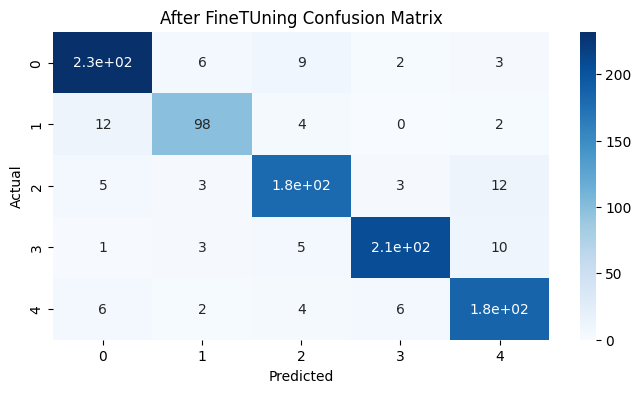

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sns.heatmap(FCM,annot=True,cmap="Blues")
plt.title('After FineTUning Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **On Unseen samples**

In [69]:
pred_data = df.sample(1000,random_state=42)
model_v1 = DistilBertForSequenceClassification.from_pretrained("/content/distilbert_finetuned")

In [73]:
pred_data['Finetuned_predictions'] = pred_data['Text'].apply(lambda x: make_prediction(str(x)[:300])[0])

In [72]:
pred_data.head(3)

,Id,Emotion,Text,label,Finetuned_predictions
1900,2690,sadness,i social and dreaming about things that make y...,3,[2]
20627,27544,worry,"is missing training tonight, the lurgy is on m...",4,[2]
12481,17415,worry,my HD is full. need to cleanup a lot,4,[2]


In [74]:
cm = confusion_matrix(pred_data['label'],pred_data['Finetuned_predictions'])
accu = cm.diagonal().sum()/cm.sum().astype(float)
print("on unseen data:\n")
print(f" Confusion Matrix : \n{cm}")
print(f" Accuracy score : {accu}")

on unseen data:

 Confusion Matrix : 
[[232   6   9   2   3]
 [ 12  98   4   0   2]
 [  5   3 181   3  12]
 [  1   3   5 206  10]
 [  6   2   4   6 185]]
 Accuracy score : 0.902


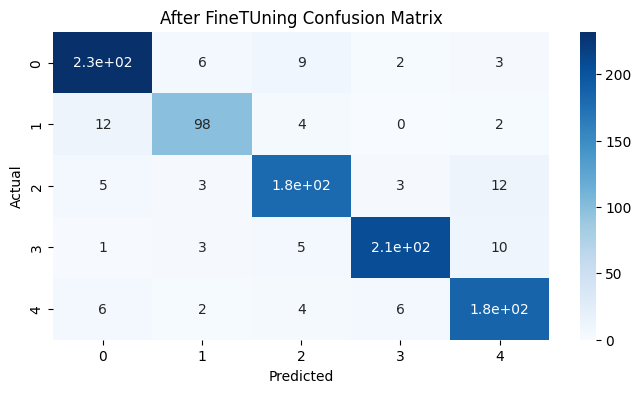

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sns.heatmap(cm,annot=True,cmap="Blues")
plt.title('After FineTUning Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **Accuracy score** : **90 %**

In [80]:
import streamlit as st


# Load your fine-tuned model and tokenizer
model_dir = "/content/distilbert_finetuned"  # Update if your model is saved elsewhere
model = DistilBertForSequenceClassification.from_pretrained(model_dir)
tokenizer = DistilBertTokenizer.from_pretrained(model_dir)

# Function to make predictions
def predict_emotion(text):
    inputs = tokenizer(text, return_tensors='pt')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    inputs = inputs.to(device)
    outputs = model(**inputs)
    predictions = outputs.logits.argmax(-1)
    predictions = predictions.cpu().detach().numpy()
    return predictions[0]  # Return the predicted emotion label

# Streamlit UI
st.title("Emotion Prediction")
text_input = st.text_area("Enter text:")

if st.button("Predict"):
    if text_input:
        emotion_label = predict_emotion(text_input)
        # Map emotion label to emotion name (adjust as needed)
        emotion_map = {
            0: "sadness",
            1: "joy",
            2: "love",
            3: "anger",
            4: "fear"
        }
        emotion = emotion_map.get(emotion_label, "unknown")
        st.write(f"Predicted Emotion: **{emotion}**")
    else:
        st.warning("Please enter some text.")

2024-12-24 15:46:39.622 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]


In [82]:
!streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.138.135.251:8501

  Stopping...
  Stopping...


In [84]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/


In [86]:
!git add /content/DistilBert_customModel_emotions

In [88]:
!git add /content/distilbert_finetuned
!git add /content/logs
!git add /content/result_bert_custom
!git add /content/sample_data
!git add /content/wandb


In [89]:
!git config --global user.email "sarathpeddireddy93477@gmail.com"  # Replace with your email
!git config --global user.name "Sarath Peddireddy"

In [90]:
!git commit -m "Initial commit with FineTuned2(distil) notebook and associated files"

[master (root-commit) 7aabc4b] Initial commit with FineTuned2(distil) notebook and associated files
 63 files changed, 82869 insertions(+)
 create mode 100644 DistilBert_customModel_emotions/config.json
 create mode 100644 DistilBert_customModel_emotions/model.safetensors
 create mode 100644 DistilBert_customModel_emotions/training_args.bin
 create mode 100644 distilbert_finetuned/config.json
 create mode 100644 distilbert_finetuned/model.safetensors
 create mode 100644 distilbert_finetuned/special_tokens_map.json
 create mode 100644 distilbert_finetuned/tokenizer_config.json
 create mode 100644 distilbert_finetuned/vocab.txt
 create mode 100644 logs/events.out.tfevents.1735052640.523c31525edb.764.0
 create mode 100644 logs/events.out.tfevents.1735053233.523c31525edb.764.1
 create mode 100644 logs/events.out.tfevents.1735053601.523c31525edb.764.2
 create mode 100644 logs/events.out.tfevents.1735053618.523c31525edb.764.3
 create mode 100644 result_bert_custom/checkpoint-1000/config.json

In [91]:
!git branch -M main
!git remote add origin https://github.com/Sarath-peddireddy/EmotionDetection-DistilBert-90-.git
!git push -u origin main

fatal: could not read Username for 'https://github.com': No such device or address
